In [48]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

Get the Data

In [34]:
# Convert dataset to dataframe
data = pd.read_csv("SBAnational.csv", low_memory=False)

Prepare and Explore the Data

In [35]:
# Function that drops the irrelevant features such as Loan ID or Borrower's name
def drop_irrelevant_features(data):
    del data["LoanNr_ChkDgt"]
    del data["Name"]
    del data["City"]
    del data["State"]
    del data["Zip"]
    del data["Bank"]
    del data["BankState"]
    del data["NAICS"]
    del data["ApprovalDate"]
    del data["ApprovalFY"]
    del data["FranchiseCode"]
    del data["ChgOffDate"]
    del data["DisbursementDate"]

# Function that handles Text and Categorical attributes. Replaces inappropriate values
def fix_text_categorical(data):
    data["DisbursementGross"] = data["DisbursementGross"].replace('[\$,]', '', regex=True).astype(float)
    data["BalanceGross"] = data["BalanceGross"].replace('[\$,]', '', regex=True).astype(float)
    data["ChgOffPrinGr"] = data["ChgOffPrinGr"].replace('[\$,]', '', regex=True).astype(float)
    data["GrAppv"] = data["GrAppv"].replace('[\$,]', '', regex=True).astype(float)
    data["SBA_Appv"] = data["SBA_Appv"].replace('[\$,]', '', regex=True).astype(float)
    data["RevLineCr"] = data["RevLineCr"].apply(lambda x: 1 if x == "Y" else 0)
    data["LowDoc"] = data["LowDoc"].apply(lambda x: 1 if x == "Y" else 0)
    data["NewExist"] = data["NewExist"].fillna(0)
    data["NewExist"] = data["NewExist"].replace(to_replace=0.0, value=2.0)
    data["MIS_Status"] = data["MIS_Status"].apply(lambda x: 1 if x == "P I F" else 0)

# Combines above functions into single preprocessing function
def preprocess_data(data):
    drop_irrelevant_features(data)
    fix_text_categorical(data)

In [36]:
preprocess_data(data)

<AxesSubplot:>

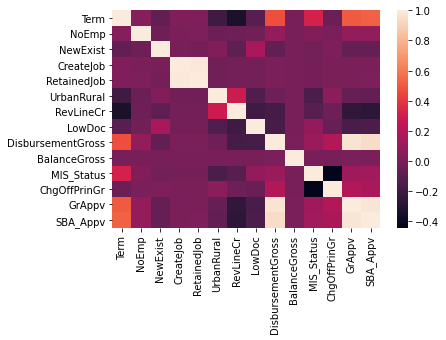

In [37]:
# Correlation matrix
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix)

<AxesSubplot:>

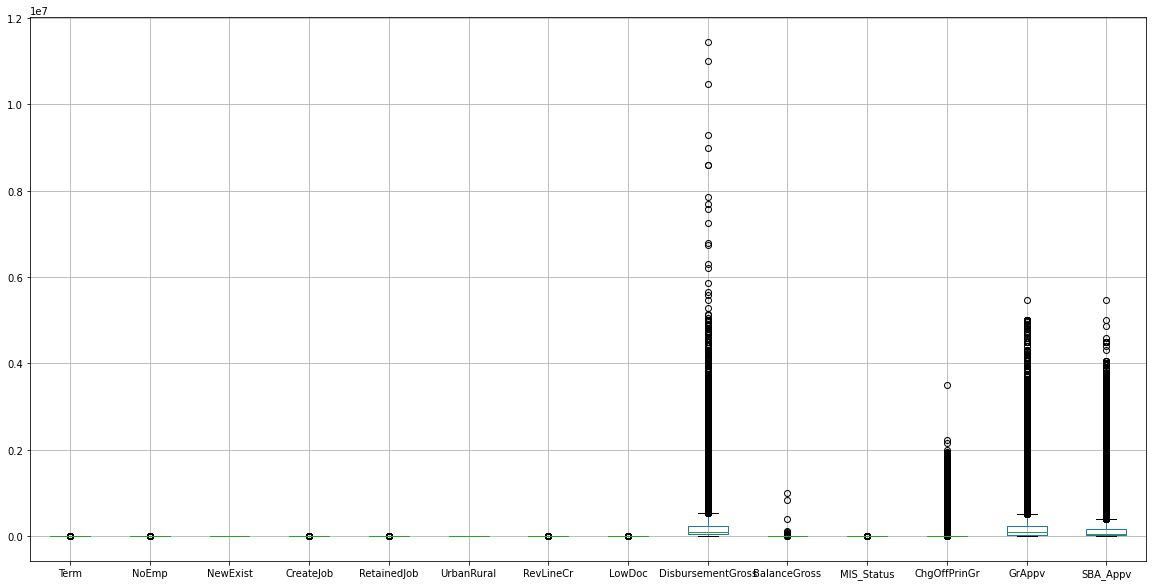

In [38]:
# Boxplots of attributes
data.boxplot(figsize=(20, 10))

array([[<AxesSubplot:title={'center':'Term'}>,
        <AxesSubplot:title={'center':'NoEmp'}>,
        <AxesSubplot:title={'center':'NewExist'}>,
        <AxesSubplot:title={'center':'CreateJob'}>],
       [<AxesSubplot:title={'center':'RetainedJob'}>,
        <AxesSubplot:title={'center':'UrbanRural'}>,
        <AxesSubplot:title={'center':'RevLineCr'}>,
        <AxesSubplot:title={'center':'LowDoc'}>],
       [<AxesSubplot:title={'center':'DisbursementGross'}>,
        <AxesSubplot:title={'center':'BalanceGross'}>,
        <AxesSubplot:title={'center':'MIS_Status'}>,
        <AxesSubplot:title={'center':'ChgOffPrinGr'}>],
       [<AxesSubplot:title={'center':'GrAppv'}>,
        <AxesSubplot:title={'center':'SBA_Appv'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

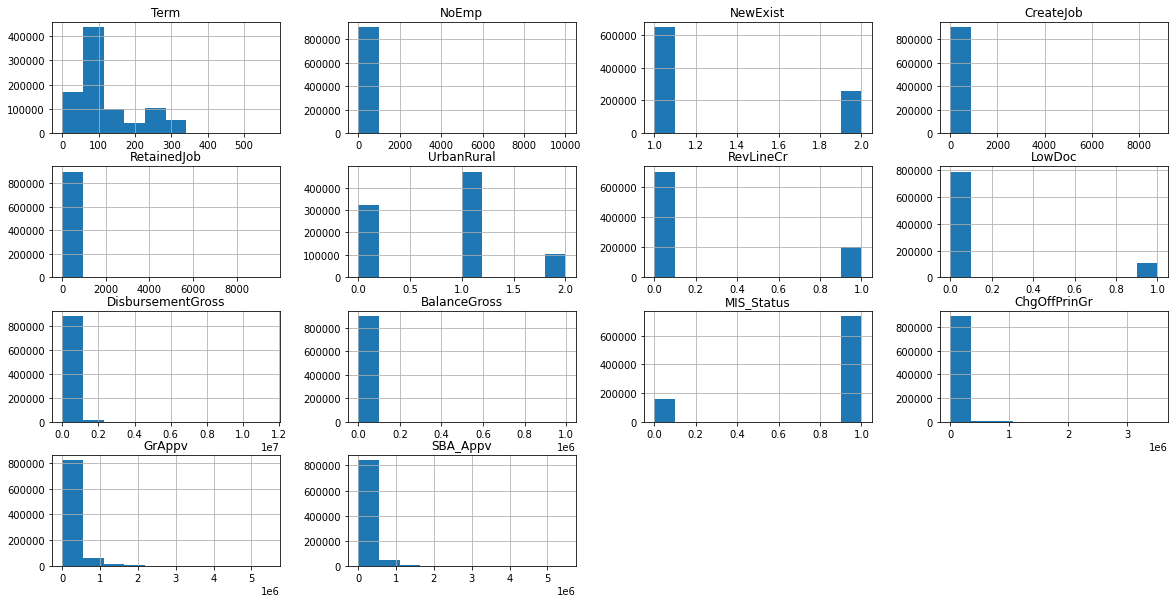

In [39]:
data.hist(figsize=(20,10))

Training Random Forests

In [40]:
# Function that prepares the datasets into X matrix and y vector
def split_data(data):
    train_set, test_set = train_test_split(data, test_size=0.1)
    y_train, y_test = train_set["MIS_Status"], test_set["MIS_Status"]
    X_train, X_test = train_set.loc[:, data.columns != "MIS_Status"], test_set.loc[:, data.columns != "MIS_Status"]
    return (X_train, y_train, X_test, y_test)

# Function that trains a random forest given an X matrix and y vector
def train_forest(X_train, y_train):
    rfc = RandomForestClassifier(n_estimators=50, n_jobs=-1)
    rfc.fit(X_train, y_train)
    return rfc

# Function that usese K-Fold Cross Validation to measure and compare performance
def display_cross_val_score(model, X_train, y_train):
    scores = cross_val_score(model, X_train, y_train, scoring="accuracy", cv=10, n_jobs=-1)
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard Deviation:", scores.std())

In [41]:
X_train, y_train, X_test, y_test = split_data(data)
rfc = train_forest(X_train, y_train)
display_cross_val_score(rfc, X_train, y_train)

Scores: [0.99350015 0.99353723 0.99380908 0.99336423 0.99315416 0.99373494
 0.99354958 0.99388315 0.99350007 0.99353715]
Mean: 0.9935569736427183
Standard Deviation: 0.00020207416405524127


Fine Tune Model

In [43]:
# Hyperparameter tuning with Grid Search Cross Validation since there are few hyperparameters to explore
param_grid = [
    {"n_estimators": [5, 25, 50], "max_depth": [3, 10, None], 
    "bootstrap": [True, False], "n_jobs": [-1]}
]

forest = RandomForestClassifier()

grid_search = GridSearchCV(forest, param_grid, cv=5, scoring="accuracy", return_train_score=True)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid=[{'bootstrap': [True, False],
                          'max_depth': [3, 10, None],
                          'n_estimators': [5, 50, 100], 'n_jobs': [-1]}],
             return_train_score=True, scoring='accuracy')

In [44]:
grid_search.best_params_

{'bootstrap': False, 'max_depth': 10, 'n_estimators': 50, 'n_jobs': -1}

ANalyze Best Model and its Errors

In [45]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([1.52117184e-01, 2.19886087e-03, 8.39836217e-04, 9.34045667e-04,
       1.49562434e-02, 8.20716872e-03, 2.61961246e-03, 6.09418314e-04,
       1.18099357e-02, 1.15279600e-07, 7.79124216e-01, 9.22335072e-03,
       1.73600125e-02])

In [46]:
final_model = grid_search.best_estimator_

final_score = final_model.score(X_test, y_test)
print(final_score)

0.9939388547215766


Solution

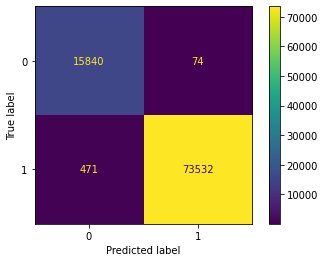

In [51]:
# Visualize the model's confusion matrix 
plot_confusion_matrix(final_model, X_test, y_test)